In [1]:
#pip install pandas numpy scikit-learn matplotlib seaborn xgboost prophet


2. Import Data and neccessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('Superstore.csv', encoding='latin-1')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [4]:
# Basic info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

2. Data cleaning

In [5]:
# Convert dates
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

df.isnull().sum() #so no nulls

# Drop unnecessary columns
df_clean = df.drop(['Row ID'], axis=1)

# Create new feature: shipping duration
df_clean['Ship Duration'] = (df_clean['Ship Date'] - df_clean['Order Date']).dt.days

# Create new feature: profit margin
df_clean['Profit Margin'] = df_clean['Profit'] / df_clean['Sales']

3. Exploratory Data Analysis (EDA)

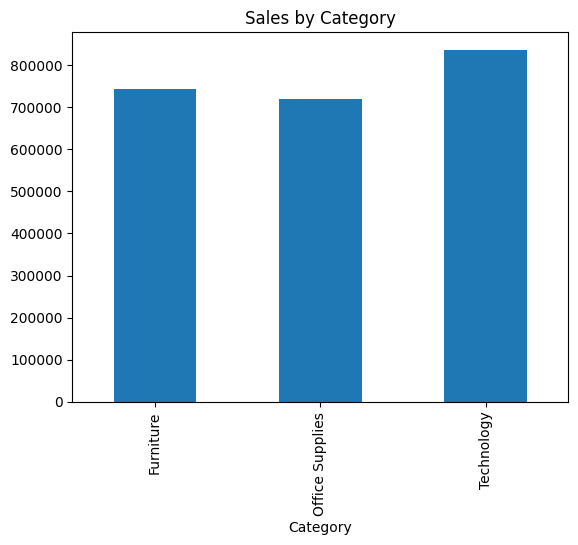

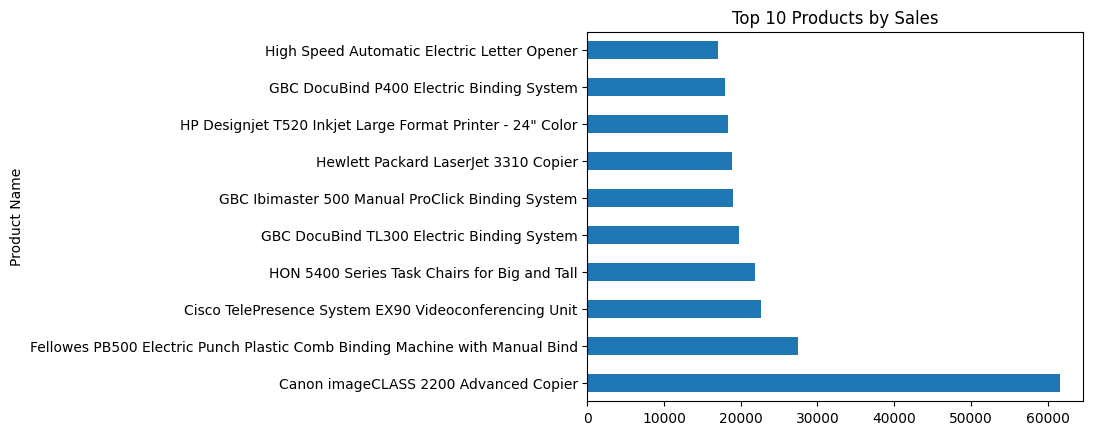

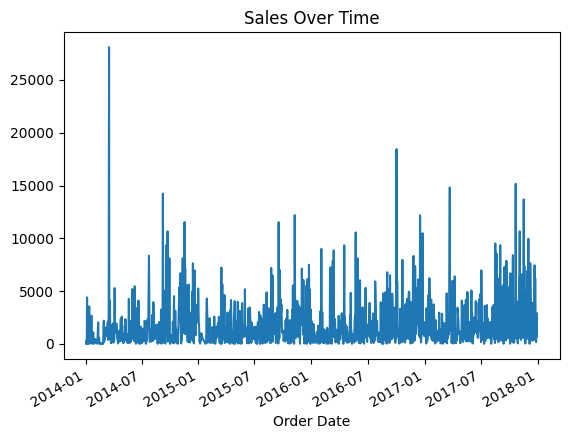

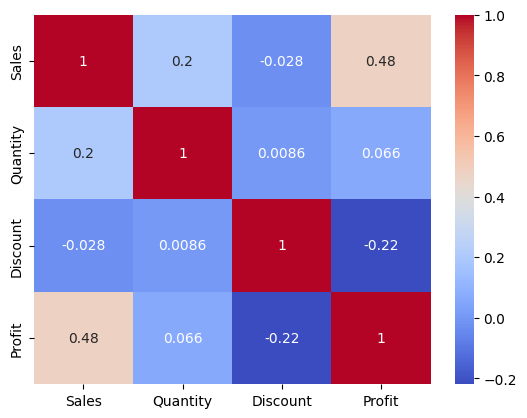

In [6]:
# Sales by category
cat_sales = df_clean.groupby('Category')['Sales'].sum()
cat_sales.plot(kind='bar', title='Sales by Category')
plt.show()

# Top 10 products by sales
top_products = df_clean.groupby('Product Name')['Sales'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='barh', title='Top 10 Products by Sales')
plt.show()

# Sales over time
df_clean.groupby('Order Date')['Sales'].sum().plot(title='Sales Over Time')
plt.show()

# Heatmap of correlations
corr = df_clean[['Sales', 'Quantity', 'Discount', 'Profit']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


## Association Rule Mining  #(skippd due to lower overlap)



In [7]:
from mlxtend.frequent_patterns import apriori, association_rules

In [8]:
# Prepare Basket Data-------
# Create basket matrix
#basket = df_clean.groupby(['Order ID', 'Product Name'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('Order ID')

# Convert quantities to 1/0
#basket = basket.map(lambda x: 1 if x > 0 else 0)


In [9]:
#Run Apriori Algorithm-------
# Convert quantities to boolean True/False
#basket = basket.map(lambda x: True if x > 0 else False) # convert to true or false due to apriori function prefer T/F

# Run apriori with lower min_support
#frequent_items = apriori(basket, min_support=0.001, use_colnames=True)

# Show top itemsets
#print(frequent_items.sort_values(by='support', ascending=False).head(10))


In [10]:
# Generate rules with low confidence threshold
#rules = association_rules(frequent_items, metric='confidence', min_threshold=0.1)

# Check if rules exist
#if not rules.empty:
#    print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))
#else:
#    print("No association rules found. Try lowering min_threshold or using another metric.")


 ## **K**-Means Customer Segmentation

Calculate RFM Features

In [11]:
from datetime import datetime

# Reference date (last order date + 1)
latest_date = df_clean['Order Date'].max() + pd.Timedelta(days=1)

# Calculate Recency: days since last purchase
rfm = df_clean.groupby('Customer ID').agg({
    'Order Date': lambda x: (latest_date - x.max()).days,
    'Order ID': 'nunique',
    'Sales': 'sum'
}).reset_index()

# Rename columns
rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

print(rfm.head())


  Customer ID  Recency  Frequency  Monetary
0    AA-10315      185          5  5563.560
1    AA-10375       20          9  1056.390
2    AA-10480      260          4  1790.512
3    AA-10645       56          6  5086.935
4    AB-10015      416          3   886.156



Visualization

•	Recency → Number of days since their most recent purchase.

•	Frequency → How many unique orders they made.

•	Monetary → Total sales (money spent) by them.


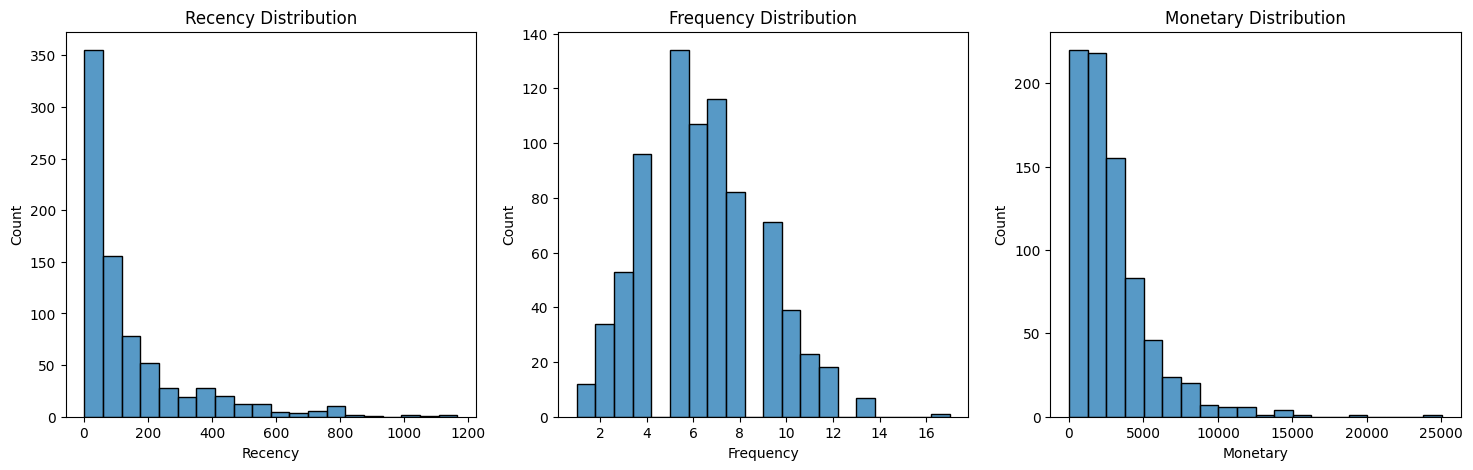

In [12]:


fig, ax = plt.subplots(1, 3, figsize=(18,5))
sns.histplot(rfm['Recency'], bins=20, ax=ax[0])
sns.histplot(rfm['Frequency'], bins=20, ax=ax[1])
sns.histplot(rfm['Monetary'], bins=20, ax=ax[2])
ax[0].set_title('Recency Distribution')
ax[1].set_title('Frequency Distribution')
ax[2].set_title('Monetary Distribution')
plt.show()


Scale the Data

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


In [14]:
from sklearn.cluster import KMeans

# Try 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

print(rfm.head())

  Customer ID  Recency  Frequency  Monetary  Cluster
0    AA-10315      185          5  5563.560        0
1    AA-10375       20          9  1056.390        0
2    AA-10480      260          4  1790.512        0
3    AA-10645       56          6  5086.935        2
4    AB-10015      416          3   886.156        1


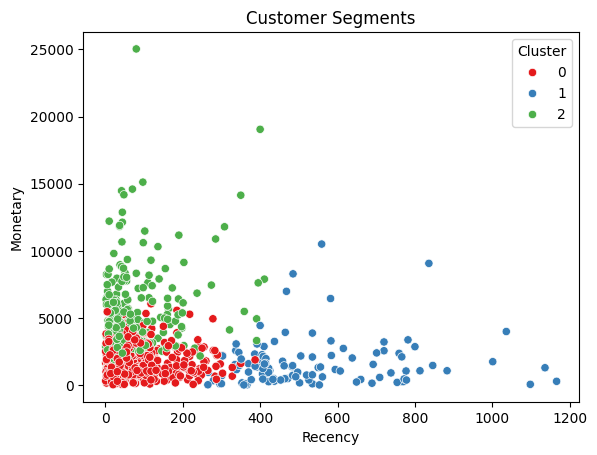

In [15]:
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set1')
plt.title('Customer Segments')
plt.show()


##SALES PREDICTION BLOCK

prepare feature

In [16]:
# Select features
features = ['Quantity', 'Discount', 'Profit', 'Ship Duration']
target = 'Sales'

# Drop rows with missing values (if any)
model_data = df_clean[features + [target]].dropna()

X = model_data[features]
y = model_data[target]


Train-Test Split

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


 Linear Regression Model

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

# Evaluation
print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_lr))
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred_lr))
print("Linear Regression R^2:", r2_score(y_test, y_pred_lr))


Linear Regression MAE: 218.16059538696962
Linear Regression MSE: 186793.7952128799
Linear Regression R^2: 0.3730058915278802


Random Forest Model

In [19]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=100)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf))
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))
print("Random Forest R^2:", r2_score(y_test, y_pred_rf))


Random Forest MAE: 92.53681724193049
Random Forest MSE: 68586.3627758969
Random Forest R^2: 0.7697822599888282


Optional: Feature Importance (Random Forest)

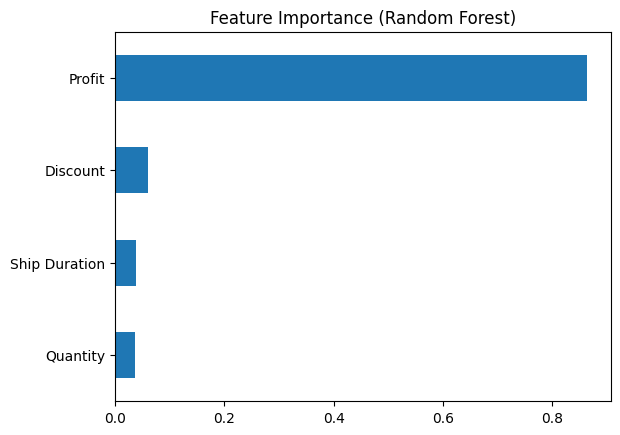

In [20]:
import matplotlib.pyplot as plt

feat_importances = pd.Series(rf_model.feature_importances_, index=features)
feat_importances.sort_values().plot(kind='barh')
plt.title('Feature Importance (Random Forest)')
plt.show()

In [21]:
df_clean.to_csv('superstore_clean.csv', index=False)